# Classification Model Development
**Victor Huarniz**
**Linkedin: https://www.linkedin.com/in/victor-h-noya/**

**DAT-5303 | Machine Learning**
**Professor: Chase Kusterer**
**Hult International Business School**

### Purpose of this Script

This script is designed to run different models and get the most accurate model which will be determined by the highest AUC Score. Other assumptions include a random_state of 219 and a test_size of 0.25, target variable is stratified, max_depth for classification tree, random forest, and gradient boosted machine (GBM) models is less than or equal to 8.<br>

Our steps include:<br>
~~~
1) Reading and massaging dataset 
2) Creating and evaluating models 
    2.1) Logistic Regression
    2.2) Full Tree 
    2.3) Pruned Tree 
    2.4) Tuned LR
    2.5) Tuned Tree
    2.6) Random Forest
    2.7) Tuned Random Forest
    2.8) Gradient Boosted Models (GBM)
    2.9) Tuned Gradient Boosted Models (GBM)
3) Summarize the models of choose of the optimal model considering metrics
~~~

## Reading and massaging dataset

### Reading packages and data

In [1]:
## Importing packages
# importing essential libraries
import pandas as pd                                  # data science essentials
import matplotlib.pyplot as plt                      # essential graphical output
import numpy as np                                   # essential math
import seaborn as sns                                # enhanced graphical output
import statsmodels.formula.api as smf                # regression modeling

# import packages for massaging
import gender_guesser.detector as gender             # to guess gender of names

# import packages for the models
from sklearn.model_selection import train_test_split # train/test split
import sklearn.linear_model                          # linear Models (scikit-learn) (OLS, Lasso, ARD)
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.neighbors import KNeighborsRegressor    # KNN for regression
from sklearn.preprocessing import StandardScaler     # standard scaler
from sklearn.linear_model import LogisticRegression  # logistic regression

# libraries for classification trees
from sklearn.tree import DecisionTreeClassifier      # classification trees
from sklearn.tree import export_graphviz             # exports graphics
from six import StringIO                             # saves objects in memory
from IPython.display import Image                    # displays on frontend
import pydotplus                                     # interprets dot objects
from sklearn.model_selection import RandomizedSearchCV# hyperparameter tuning
from sklearn.metrics import make_scorer              # customizable scorer
from sklearn.ensemble import RandomForestClassifier  # random forest
from sklearn.ensemble import GradientBoostingClassifier# gbm

## Reading datasets
# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# specifying file names
dataset_file = './data/Apprentice_Chef_Dataset.xlsx'
dictionary_file = './data/Apprentice_Chef_Data_Dictionary.xlsx'

# reading the files into Python
chef = pd.read_excel(dataset_file)
dictionary = pd.read_excel(dictionary_file)

### Massaging data

In [2]:
## creating a copy of the original data set: "chef_new"

chef_new = chef.copy()
########################################################################################################################
########################################################################################################################
########################################################################################################################

## Renaming variables
# LARGEST_ORDER_SIZE -> AVG_ORDER_SIZE

chef_new.rename(columns={'LARGEST_ORDER_SIZE': 'AVG_ORDER_SIZE'}, inplace=True)

# MOBILE_NUMBER -> HAVE_MOBILE_NUMBER

chef_new.rename(columns={'MOBILE_NUMBER': 'HAVE_MOBILE_NUMBER'}, inplace=True)

########################################################################################################################
########################################################################################################################
########################################################################################################################

## Classifying personal and work emails by domain

# placeholder list
placeholder_lst = []

# looping over each email address
for index, col in chef_new.iterrows():

    # splitting email domain at '@'
    split_email = chef_new.loc[index, 'EMAIL'].split(sep="@")

    # appending placeholder_lst with the results
    placeholder_lst.append(split_email)

# converting placeholder_lst into a DataFrame
email_df = pd.DataFrame(placeholder_lst)

# renaming column to concatenate
email_df.columns = ['0', 'email_domain']

# concatenating personal_email_domain with friends DataFrame
chef_new = pd.concat([chef_new, email_df['email_domain']], axis=1)

# email domain types
personal_email_domains = [
    '@gmail.com', '@hotmail.com', '@live.com', '@me.com', '@yahoo.com',
    '@msn.com', '@protonmail.com'
]

# placeholder list
placeholder_lst = []

# looping to group observations by domain type
for domain in chef_new['email_domain']:
    if "@" + domain in personal_email_domains:
        placeholder_lst.append('personal')

    else:
        placeholder_lst.append('worker')

# concatenating with original DataFrame
chef_new['domain_group'] = pd.Series(placeholder_lst)

########################################################################################################################
########################################################################################################################
########################################################################################################################

## New columns to define new variables from other columns

# "EFF_CLICKS_ABV_MEAN" Show if clicks above average give more orders: if above average -> orders/clicks

# looping over each email address
for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[
            index,
            'AVG_CLICKS_PER_VISIT'] > chef_new['AVG_CLICKS_PER_VISIT'].mean():
        chef_new.loc[index, 'EFF_CLICKS_ABV_MEAN'] = chef_new.loc[
            index,
            'TOTAL_MEALS_ORDERED'] / chef_new.loc[index,
                                                  'AVG_CLICKS_PER_VISIT']
    else:
        chef_new.loc[index, 'EFF_CLICKS_ABV_MEAN'] = 0

# "EFF_CLICKS_BELOW_MEAN" Show if clicks above average give more orders: if below or equal average -> orders/clicks

# looping over each email address
for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[
            index,
            'AVG_CLICKS_PER_VISIT'] <= chef_new['AVG_CLICKS_PER_VISIT'].mean():
        chef_new.loc[index, 'EFF_CLICKS_BELOW_MEAN'] = chef_new.loc[
            index,
            'TOTAL_MEALS_ORDERED'] / chef_new.loc[index,
                                                  'AVG_CLICKS_PER_VISIT']
    else:
        chef_new.loc[index, 'EFF_CLICKS_BELOW_MEAN'] = 0

# "HIGH_CUSTOMER_SERVICE" Efficiency of customer service (if above median, bad):

# looping over CUSTOMER_SERVICE
for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[index, 'CONTACTS_W_CUSTOMER_SERVICE'] >= chef_new[
            'CONTACTS_W_CUSTOMER_SERVICE'].median():
        chef_new.loc[index, 'HIGH_CUSTOMER_SERVICE'] = 1
    else:
        chef_new.loc[index, 'HIGH_CUSTOMER_SERVICE'] = 0

# "PC_FAN" Efficiency of PC_LOGINS (if above median, fan):

# looping over PC_LOGINS
for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[index, 'PC_LOGINS'] >= chef_new['PC_LOGINS'].median():
        chef_new.loc[index, 'PC_FAN'] = 1
    else:
        chef_new.loc[index, 'PC_FAN'] = 0

########################################################################################################################
########################################################################################################################
########################################################################################################################

## Creating new variables

# "EFF_PC_PLATFORM" Efficiency of categories: HAVE_MOBILE_NUMBER * PC_LOGINS

chef_new[
    'EFF_PC_PLATFORM'] = chef_new['HAVE_MOBILE_NUMBER'] * chef_new['PC_LOGINS']

# "EFF_CATEGORIES" Efficiency of categories: TOTAL_MEALS_ORDERED / PRODUCT_CATEGORIES_VIEWED

chef_new['EFF_CATEGORIES'] = chef_new['TOTAL_MEALS_ORDERED'] / chef_new[
    'PRODUCT_CATEGORIES_VIEWED']

# Log Revenue

chef_new['log_REVENUE'] = np.log10(chef_new['REVENUE'])

########################################################################################################################
########################################################################################################################
########################################################################################################################

## Get dummies variables for categorical variables

# one hot encoding categorical variables
one_hot_rating = pd.get_dummies(chef_new['MEDIAN_MEAL_RATING'])
one_hot_classes = pd.get_dummies(chef_new['MASTER_CLASSES_ATTENDED'])
one_hot_domain_group = pd.get_dummies(chef_new['domain_group'])
one_hot_email_domain = pd.get_dummies(chef_new['email_domain'])

# labels

one_hot_rating.columns = [
    'RATING_1', 'RATING_2', 'RATING_3', 'RATING_4', 'RATING_5'
]
one_hot_classes.columns = ['CLASSES_0', 'CLASSES_1', 'CLASSES_2', 'CLASSES_3']
one_hot_domain_group.columns = ['PERSONAL_EMAIL', 'WORK_EMAIL']
one_hot_email_domain.columns = [
    'amex_email', 'aol_email', 'apple_email', 'boeing_email',
    'caterpillar_email', 'chevron_email', 'cisco_email', 'cocacola_email',
    'disney_email', 'dupont_email', 'exxon_email', 'ge_email', 'gmail_email',
    'goldmansacs_email', 'homedepot_email', 'hotmail_email', 'ibm_email',
    'intel_email', 'jnj_email', 'jpmorgan_email', 'live_email',
    'mcdonalds_email', 'me_email', 'merck_email', 'microsoft_email',
    'mmm_email', 'msn_email', 'nike_email', 'passport_email', 'pfizer_email',
    'pg_email', 'protonmail_email', 'travelers_email', 'unitedhealth_email',
    'unitedtech_email', 'verizon_email', 'visa_email', 'walmart_email',
    'yahoo_email'
]

# dropping categorical variables after they've been encoded
#chef_new = chef_new.drop('MEDIAN_MEAL_RATING', axis=1)
chef_new = chef_new.drop('MASTER_CLASSES_ATTENDED', axis=1)
chef_new = chef_new.drop('domain_group', axis=1)
chef_new = chef_new.drop('email_domain', axis=1)

# joining codings together
chef_new = chef_new.join([
    one_hot_rating, one_hot_classes, one_hot_domain_group, one_hot_email_domain
])

# saving new columns
new_columns = chef_new.columns

# creating a (Pearson) correlation matrix
chef_corr = chef_new.corr().round(2)

#printing (Pearson) correlations with SalePrice
print(chef_corr.loc['CROSS_SELL_SUCCESS'].sort_values(ascending=False))

########################################################################################################################
########################################################################################################################
########################################################################################################################

# New variables from dummies

# "GOOD_ORDERS". Number of orders with 4 or 5 stars:

for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[index, 'RATING_4'] + chef_new.loc[index, 'RATING_5'] >= 1:
        chef_new.loc[index, 'GOOD_ORDERS'] = 1
    else:
        chef_new.loc[index, 'GOOD_ORDERS'] = 0

# "GO_TO_CLASS". Number of people that attend at least one class:

for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[index, 'CLASSES_1'] + chef_new.loc[
            index, 'CLASSES_2'] + chef_new.loc[index, 'CLASSES_3'] >= 1:
        chef_new.loc[index, 'GO_TO_CLASS'] = 1
    else:
        chef_new.loc[index, 'GO_TO_CLASS'] = 0

# droping names

chef_new = chef_new.drop([
    'NAME', 'EMAIL', 'FIRST_NAME','FAMILY_NAME', 'walmart_email',
    'cisco_email', 'ge_email', 'gmail_email', 'boeing_email',
     'visa_email', 'RATING_4', 
    'travelers_email', 'EFF_CLICKS_BELOW_MEAN', 'mmm_email', 'chevron_email',
    'ibm_email',  'disney_email', 'dupont_email',
    'CLASSES_2', 'EFF_CATEGORIES', 'jnj_email', 'REVENUE', 'yahoo_email',
    'exxon_email', 'UNIQUE_MEALS_PURCH', 'PRODUCT_CATEGORIES_VIEWED',
    'RATING_3',  'RATING_2', 'homedepot_email', 'RATING_1'
],
                         axis=1)

CROSS_SELL_SUCCESS             1.00
CANCELLATIONS_BEFORE_NOON      0.16
WORK_EMAIL                     0.11
EFF_PC_PLATFORM                0.11
HAVE_MOBILE_NUMBER             0.10
TASTES_AND_PREFERENCES         0.08
REFRIGERATED_LOCKER            0.07
merck_email                    0.07
microsoft_email                0.07
jpmorgan_email                 0.06
amex_email                     0.06
pg_email                       0.06
CLASSES_1                      0.05
intel_email                    0.05
PC_FAN                         0.04
caterpillar_email              0.04
PACKAGE_LOCKER                 0.04
unitedhealth_email             0.04
PC_LOGINS                      0.04
HIGH_CUSTOMER_SERVICE          0.04
CONTACTS_W_CUSTOMER_SERVICE    0.04
mcdonalds_email                0.03
verizon_email                  0.03
apple_email                    0.03
RATING_5                       0.03
nike_email                     0.03
pfizer_email                   0.03
walmart_email               

In [3]:
# USER DEFINED FUNCTIONS
########################################
# optimal_neighbors
########################################
def optimal_neighbors(x_data,
                      y_data,
                      standardize = True,
                      pct_test=0.25,
                      seed=219,
                      response_type='reg',
                      max_neighbors=20,
                      show_viz=True):
    """
Exhaustively compute training and testing results for KNN across
[1, max_neighbors]. Outputs the maximum test score and (by default) a
visualization of the results.
PARAMETERS
----------
X_data        : explanatory variable data
y_data        : response variable
standardize   : whether or not to standardize the X data, default True
pct_test      : test size for training and validation from (0,1), default 0.25
seed          : random seed to be used in algorithm, default 219
response_type : type of neighbors algorithm to use, default 'reg'
    Use 'reg' for regression (KNeighborsRegressor)
    Use 'class' for classification (KNeighborsClassifier)
max_neighbors : maximum number of neighbors in exhaustive search, default 20
show_viz      : display or surpress k-neigbors visualization, default True
"""    
    
    
    if standardize == True:
        # optionally standardizing X_data
        scaler             = StandardScaler()
        scaler.fit(x_data)
        x_scaled           = scaler.transform(x_data)
        x_scaled_df        = pd.DataFrame(x_scaled)
        x_data             = x_scaled_df



    # train-test split
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size = pct_test,
                                                        random_state = seed)


    # creating lists for training set accuracy and test set accuracy
    training_accuracy = []
    test_accuracy = []
    
    
    # setting neighbor range
    neighbors_settings = range(1, max_neighbors + 1)


    for n_neighbors in neighbors_settings:
        # building the model based on response variable type
        if response_type == 'reg':
            clf = KNeighborsRegressor(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)
            
        elif response_type == 'class':
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(x_train, y_train)            
            
        else:
            print("Error: response_type must be 'reg' or 'class'")
        
        
        # recording the training set accuracy
        training_accuracy.append(clf.score(x_train, y_train))
    
        # recording the generalization accuracy
        test_accuracy.append(clf.score(x_test, y_test))


    # optionally displaying visualization
    if show_viz == True:
        # plotting the visualization
        fig, ax = plt.subplots(figsize=(12,8))
        plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
        plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("n_neighbors")
        plt.legend()
        plt.show()
    
    
    # returning optimal number of neighbors
    print(f"The optimal number of neighbors is: {test_accuracy.index(max(test_accuracy))+1}")
    return test_accuracy.index(max(test_accuracy))+1


########################################
# visual_cm
########################################
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)


    # heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()
########################################
# display_tree
########################################
def display_tree(tree, feature_df, height = 500, width = 800):
    """
    PARAMETERS
    ----------
    tree       : fitted tree model object
        fitted CART model to visualized
    feature_df : DataFrame
        DataFrame of explanatory features (used to generate labels)
    height     : int, default 500
        height in pixels to which to constrain image in html
    width      : int, default 800
        width in pixels to which to constrain image in html
    """

    # visualizing the tree
    dot_data = StringIO()

    
    # exporting tree to graphviz
    export_graphviz(decision_tree      = tree,
                    out_file           = dot_data,
                    filled             = True,
                    rounded            = True,
                    special_characters = True,
                    feature_names      = feature_df.columns)


    # declaring a graph object
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())


    # creating image
    img = Image(graph.create_png(),
                height = height,
                width  = width)
    
    return img

########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = x_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(pd.np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')

## Creating and evaluating models

### Logistic Regression

In [4]:
#Initial approach
# declaring explanatory variables
chef_data = chef_new.drop('CROSS_SELL_SUCCESS', axis=1)

# declaring response variable
chef_target = chef_new.loc[:, 'CROSS_SELL_SUCCESS']

# train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(chef_data,
                                                    chef_target,
                                                    test_size=0.25,
                                                    random_state=219,
                                                    stratify=chef_target)

# merging training data for statsmodels
chef_train = pd.concat([x_train, y_train], axis=1)

#for val in chef_data:
#    print(f" {val} + ")

# instantiating a logistic regression model object
logistic_small = smf.logit(
    formula="""CROSS_SELL_SUCCESS ~      CONTACTS_W_CUSTOMER_SERVICE + 
                                         HAVE_MOBILE_NUMBER + 
                                         CANCELLATIONS_BEFORE_NOON + 
                                         CANCELLATIONS_AFTER_NOON + 
                                         TASTES_AND_PREFERENCES + 
                                         PC_LOGINS + 
                                         MOBILE_LOGINS + 
                                         PACKAGE_LOCKER + 
                                         REFRIGERATED_LOCKER + 
                                         AVG_PREP_VID_TIME + 
                                         AVG_CLICKS_PER_VISIT + 
                                         HIGH_CUSTOMER_SERVICE + 
                                         PC_FAN + 
                                         EFF_PC_PLATFORM + 
                                         RATING_5 + 
                                         CLASSES_0 + 
                                         CLASSES_1 + 
                                         CLASSES_3 + 
                                         MEDIAN_MEAL_RATING+
                                         PERSONAL_EMAIL + 
                                         WORK_EMAIL + 
                                         amex_email + 
                                         aol_email + 
                                         apple_email + 
                                         caterpillar_email + 
                                         cocacola_email + 
                                         goldmansacs_email + 
                                         hotmail_email + 
                                         intel_email + 
                                         jpmorgan_email + 
                                         live_email + 
                                         mcdonalds_email + 
                                         me_email + 
                                         merck_email + 
                                         microsoft_email + 
                                         msn_email + 
                                         nike_email + 
                                         passport_email + 
                                         pfizer_email + 
                                         pg_email + 
                                         protonmail_email + 
                                         unitedhealth_email + 
                                         unitedtech_email + 
                                         verizon_email + 
                                         GOOD_ORDERS + 
                                         GO_TO_CLASS+
                                         log_REVENUE""",
    data=chef_train)

# fitting the model object
results_logistic = logistic_small.fit()

# checking the results SUMMARY
print(results_logistic.summary())

#print(results_logistic.params)
print(results_logistic.pvalues[results_logistic.pvalues<=0.1])

         Current function value: 0.534059
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:     CROSS_SELL_SUCCESS   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1413
Method:                           MLE   Df Model:                           45
Date:                Tue, 26 Jan 2021   Pseudo R-squ.:                  0.1495
Time:                        19:24:59   Log-Likelihood:                -779.19
converged:                      False   LL-Null:                       -916.19
Covariance Type:            nonrobust   LLR p-value:                 1.370e-34
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       1.0464   4.81e+06   2.18e-07      1.000   -9.42e+06    9.42e+06
CONTACTS_W_CUS

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [5]:
# Preparing training/testing data and possible variations
# creating a dictionary to store candidate models
candidate_dict = {

# 1 full model 0.6855

#Tuned Parameters  : {'warm_start': False, 'n_estimators': 850, 'max_features': 'log2', 'max_depth': 1, 'learning_rate': 0.9}
#Tuned Training AUC: 0.6387
#Training ACCURACY: 0.7622
#Testing  ACCURACY: 0.7659
#AUC Score        : 0.6855

#True Negatives : 72
#False Positives: 84
#False Negatives: 30
#True Positives : 301
    
    'logit_full_1': [
        'CONTACTS_W_CUSTOMER_SERVICE', 'HAVE_MOBILE_NUMBER',
        'CANCELLATIONS_BEFORE_NOON', 'CANCELLATIONS_AFTER_NOON',
        'TASTES_AND_PREFERENCES', 'PC_LOGINS', 'MOBILE_LOGINS',
        'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER', 'AVG_PREP_VID_TIME',
        'AVG_CLICKS_PER_VISIT', 'HIGH_CUSTOMER_SERVICE', 'PC_FAN',
        'EFF_PC_PLATFORM', 'RATING_5', 'CLASSES_0', 'CLASSES_1', 'CLASSES_3',
        'PERSONAL_EMAIL', 'WORK_EMAIL', 'amex_email', 'aol_email',
        'apple_email', 'caterpillar_email', 'cocacola_email',
        'goldmansacs_email', 'hotmail_email', 'intel_email', 'jpmorgan_email',
        'live_email', 'mcdonalds_email', 'me_email', 'merck_email',
        'microsoft_email', 'msn_email', 'nike_email', 'passport_email',
        'pfizer_email', 'pg_email', 'protonmail_email', 'unitedhealth_email',
        'unitedtech_email', 'verizon_email', 'GOOD_ORDERS', 'GO_TO_CLASS'
    ],

# 2 full logit + log_revenue BEST explanatory variables
#                   Model Name  AUC Score  Training Accuracy  Testing Accuracy    Confusion Matrix
#0                    Logistic     0.6117             0.7258            0.7187  (49, 107, 30, 301)
#1                   Full Tree     0.5935             1.0000            0.6386   (73, 83, 93, 238)
#2                 Pruned Tree     0.6041             0.7300            0.6899   (57, 99, 52, 279)
#3                    LR Tuned     0.6342             0.7368            0.7331  (56, 100, 30, 301)
#4                  Tuned Tree     0.6012             0.7032            0.7228  (41, 115, 20, 311)
#5        Random Forest (Full)     0.5993             1.0000            0.7064  (47, 109, 34, 297)
#6  Tuned Random Forest (Full)     0.6908             0.7944            0.8008    (60, 96, 1, 330) # SECOND BEST MODEL
#7                  GBM (Full)     0.5911             0.9966            0.6838  (52, 281, 50, 281)
#8                   Tuned GBM     1.0000             1.0000            1.0000    (156, 0, 0, 331) # WINNING MODEL
    
    
    'logit_full': [
        'CONTACTS_W_CUSTOMER_SERVICE', 'HAVE_MOBILE_NUMBER',
        'CANCELLATIONS_BEFORE_NOON', 'CANCELLATIONS_AFTER_NOON',
        'TASTES_AND_PREFERENCES', 'PC_LOGINS', 'MOBILE_LOGINS',
        'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER', 'AVG_PREP_VID_TIME',
        'AVG_CLICKS_PER_VISIT', 'HIGH_CUSTOMER_SERVICE', 'PC_FAN',
        'EFF_PC_PLATFORM', 'RATING_5', 'CLASSES_0', 'CLASSES_1', 'CLASSES_3',
        'PERSONAL_EMAIL', 'WORK_EMAIL', 'amex_email', 'aol_email',
        'apple_email', 'caterpillar_email', 'cocacola_email',
        'goldmansacs_email', 'hotmail_email', 'intel_email', 'jpmorgan_email',
        'live_email', 'mcdonalds_email', 'me_email', 'merck_email',
        'microsoft_email', 'msn_email', 'nike_email', 'passport_email',
        'pfizer_email', 'pg_email', 'protonmail_email', 'unitedhealth_email',
        'unitedtech_email', 'verizon_email', 'GOOD_ORDERS', 'GO_TO_CLASS','log_REVENUE',
        'TOTAL_MEALS_ORDERED','LATE_DELIVERIES','WEEKLY_PLAN','AVG_TIME_PER_SITE_VISIT','EARLY_DELIVERIES','AVG_ORDER_SIZE','TOTAL_PHOTOS_VIEWED', 
        'EFF_CLICKS_ABV_MEAN'
    ],

# 3 logit with no cancellations
#    Model         AUC Score      TN, FP, FN, TP
#-----         ---------      --------------
#Logistic      0.6053         (47, 109, 30, 301)
#Full Tree     0.5193         (64, 92, 123, 208)
#Pruned Tree   0.6019         (45, 111, 28, 303)
#LR Tuned      0.6136         (51, 105, 33, 298)
#Tuned Tree      0.5953         (42, 114, 26, 305)
#Random Forest (Full)      0.5588         (57, 99, 82, 249)
#Tuned Random Forest (Full)      0.6365         (44, 112, 3, 328)
#GBM (Full)      0.5748         (37, 302, 29, 302)
#Tuned GBM      0.6376         (58, 98, 32, 299)

    'logit_sig_no_cancellations': [
         'TASTES_AND_PREFERENCES',
        'REFRIGERATED_LOCKER', 'aol_email', 'hotmail_email', 'live_email',
        'me_email', 'merck_email', 'microsoft_email', 'msn_email',
        'passport_email', 'AVG_PREP_VID_TIME', 'AVG_CLICKS_PER_VISIT',
        'CONTACTS_W_CUSTOMER_SERVICE', 'MOBILE_LOGINS', 'GOOD_ORDERS'
    ],

# 4 significant variables only (set 1) 0.6549
#Logistic      0.6191         (48, 108, 23, 308)
#Full Tree     0.545         (64, 92, 106, 225)
#Pruned Tree   0.5618         (24, 132, 10, 321)
#LR Tuned      0.6238         (49, 107, 22, 309)
#Tuned Tree      0.5982         (41, 115, 22, 309)
#Random Forest (Full)      0.5917         (55, 101, 56, 275)
#Tuned Random Forest (Full)      0.5861         (33, 123, 13, 318)
#GBM (Full)      0.6149         (50, 301, 30, 301)
#Tuned GBM      0.6549         (62, 94, 29, 302)    
    
    'logit_sig': [
        'CANCELLATIONS_BEFORE_NOON', 'TASTES_AND_PREFERENCES',
        'REFRIGERATED_LOCKER', 'aol_email', 'hotmail_email', 'live_email',
        'me_email', 'merck_email', 'microsoft_email', 'msn_email',
        'passport_email', 'AVG_PREP_VID_TIME', 'AVG_CLICKS_PER_VISIT',
        'CONTACTS_W_CUSTOMER_SERVICE', 'MOBILE_LOGINS', 'GOOD_ORDERS'
    ],
    
# 5 significant variables only (tree 1, variables with importance > 0)
    'tree_1': [
        'GO_TO_CLASS', 'GOOD_ORDERS', 'protonmail_email', 'msn_email',
        'me_email', 'merck_email',
        'hotmail_email', 'aol_email', 'PERSONAL_EMAIL', 'WORK_EMAIL',
        'CLASSES_0', 'CLASSES_1', 'CONTACTS_W_CUSTOMER_SERVICE',
        'HAVE_MOBILE_NUMBER', 'CANCELLATIONS_BEFORE_NOON',
        'CANCELLATIONS_AFTER_NOON', 'TASTES_AND_PREFERENCES', 'PC_LOGINS',
        'MOBILE_LOGINS', 'PACKAGE_LOCKER', 'REFRIGERATED_LOCKER',
        'AVG_PREP_VID_TIME', 'AVG_CLICKS_PER_VISIT', 'HIGH_CUSTOMER_SERVICE',
        'PC_FAN', 'EFF_PC_PLATFORM'
    ],

# 6 significant variables only (tree 2, variables with importance > 0.03) 0.53
    'tree_2': [
        'CONTACTS_W_CUSTOMER_SERVICE', 'CANCELLATIONS_BEFORE_NOON',
        'CANCELLATIONS_AFTER_NOON', 'MOBILE_LOGINS', 
        'AVG_PREP_VID_TIME', 'AVG_CLICKS_PER_VISIT', 'EFF_PC_PLATFORM'
    ],
    
# 7 significant variables only (pruned tree 3, variables with importance > 0.05) 0.5897 (tuned tree, no forest)
    'tree_3': [
        'AVG_PREP_VID_TIME','CANCELLATIONS_AFTER_NOON','HAVE_MOBILE_NUMBER','CONTACTS_W_CUSTOMER_SERVICE','PERSONAL_EMAIL','hotmail_email', 'aol_email'
    ],
    
# 8 significant variables only (pruned tree full 4, variables with importance > 0.05) 0.6295
    'tree_4': [
        'passport_email','hotmail_email','WORK_EMAIL','aol_email','CANCELLATIONS_BEFORE_NOON'],

# 9 significant variables tree with less false positives #################TRYYYYYY
    'tree_5': [
       'aol_email' , 'live_email','hotmail_email', 'MOBILE_LOGINS','msn_email','CONTACTS_W_CUSTOMER_SERVICE'],     
  
# 10 significant variables only (set 2, pvalues <=0.1) 0.6268
    
#                       Model Name  AUC Score  Training Accuracy  Testing Accuracy    Confusion Matrix
#0                    Logistic     0.6093             0.7265            0.7269  (44, 112, 21, 310)
#1                   Full Tree     0.6004             0.7478            0.7125  (45, 111, 29, 302)
#2                 Pruned Tree     0.5618             0.7114            0.7084  (24, 132, 10, 321)
#3                    LR Tuned     0.6174             0.7265            0.7310  (47, 109, 22, 309)
#4                  Tuned Tree     0.6153             0.7286            0.7351  (44, 112, 17, 314)
#5        Random Forest (Full)     0.6080             0.7478            0.7228  (45, 111, 24, 307)
#6  Tuned Random Forest (Full)     0.6086             0.7416            0.7351  (40, 116, 13, 318)
#7                  GBM (Full)     0.5997             0.7430            0.7207  (41, 310, 21, 310)
#8                   Tuned GBM     0.6268             0.7320            0.7392  (49, 107, 20, 311)
    
    
    'sig_2': [
        'CANCELLATIONS_BEFORE_NOON', 'TASTES_AND_PREFERENCES',
        'REFRIGERATED_LOCKER', 'aol_email', 'hotmail_email', 'live_email',
        'me_email', 'merck_email', 'microsoft_email', 'msn_email',
        'passport_email'
    ]
}

# train/test split with the full model
chef_data = chef_new.loc[:, candidate_dict['logit_full']]
chef_target = chef_new.loc[:, 'CROSS_SELL_SUCCESS']

# this is the exact code we were using before
x_train, x_test, y_train, y_test = train_test_split(chef_data,
                                                    chef_target,
                                                    random_state=219,
                                                    test_size=0.25,
                                                    stratify=chef_target)

In [6]:
# INSTANTIATING a logistic regression model
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 219)


# FITTING the training data
logreg_fit = logreg.fit(x_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test)


# SCORING the results
print('LogReg Training ACCURACY:', logreg_fit.score(x_train, y_train).round(4))
print('LogReg Testing  ACCURACY:', logreg_fit.score(x_test, y_test).round(4))

# saving scoring data for future use
logreg_train_score = logreg_fit.score(x_train, y_train).round(4) # accuracy
logreg_test_score  = logreg_fit.score(x_test, y_test).round(4)   # accuracy


# displaying and saving the gap between training and testing
print('LogReg Train-Test Gap   :', abs(logreg_train_score - logreg_test_score).round(4))
logreg_test_gap = abs(logreg_train_score - logreg_test_score).round(4)

# unpacking the confusion matrix
logreg_tn, \
logreg_fp, \
logreg_fn, \
logreg_tp = confusion_matrix(y_true = y_test, y_pred = logreg_pred).ravel()

# saving AUC score for future use
logreg_auc_score = roc_auc_score(y_true  = y_test,
                                 y_score = logreg_pred).round(decimals = 4)

#print AUC score
print('LogReg AUC Score   :', abs(logreg_auc_score).round(4))

# printing each result one-by-one
print(f"""
True Negatives : {logreg_tn}
False Positives: {logreg_fp}
False Negatives: {logreg_fn}
True Positives : {logreg_tp}
""")

# zipping each feature name to its coefficient
logreg_model_values = zip(chef_data.columns,
                          logreg_fit.coef_.ravel().round(decimals = 2))


# setting up a placeholder list to store model features
logreg_model_lst = [('intercept', logreg_fit.intercept_[0].round(decimals = 2))]


# printing out each feature-coefficient pair one by one
for val in logreg_model_values:
    logreg_model_lst.append(val)

LogReg Training ACCURACY: 0.7046
LogReg Testing  ACCURACY: 0.6879
LogReg Train-Test Gap   : 0.0167
LogReg AUC Score   : 0.5332

True Negatives : 16
False Positives: 140
False Negatives: 12
True Positives : 319



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Full Tree

Full Tree Training ACCURACY: 1.0
Full Tree Testing ACCURACY : 0.5996
Full Tree AUC Score: 0.5377

True Negatives : 57
False Positives: 99
False Negatives: 96
True Positives : 235

<IPython.core.display.Image object>


<ipython-input-3-b0e77273b66b>:195: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  plt.yticks(pd.np.arange(n_features), train.columns)


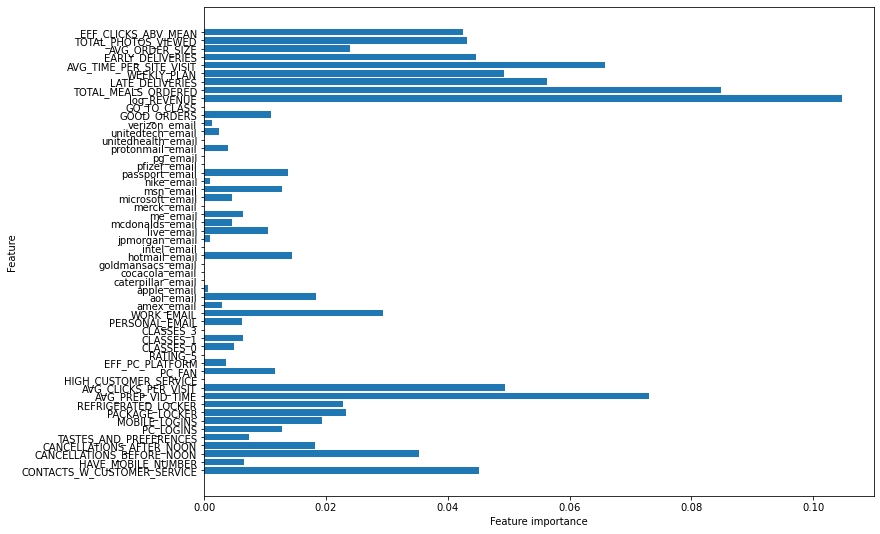

In [7]:
# INSTANTIATING a classification tree object
full_tree = DecisionTreeClassifier()


# FITTING the training data
full_tree_fit = full_tree.fit(x_train, y_train)


# PREDICTING on new data
full_tree_pred = full_tree_fit.predict(x_test)


# SCORING the model
print('Full Tree Training ACCURACY:', full_tree_fit.score(x_train,
                                                     y_train).round(4))

print('Full Tree Testing ACCURACY :', full_tree_fit.score(x_test,
                                                     y_test).round(4))

print('Full Tree AUC Score:', roc_auc_score(y_true  = y_test,
                                            y_score = full_tree_pred).round(4))


# saving scoring data for future use
full_tree_train_score = full_tree_fit.score(x_train, y_train).round(4) # accuracy
full_tree_test_score  = full_tree_fit.score(x_test, y_test).round(4)   # accuracy


# saving AUC
full_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                      y_score = full_tree_pred).round(4) # auc

# unpacking the confusion matrix
full_tree_tn, \
full_tree_fp, \
full_tree_fn, \
full_tree_tp = confusion_matrix(y_true = y_test, y_pred = full_tree_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {full_tree_tn}
False Positives: {full_tree_fp}
False Negatives: {full_tree_fn}
True Positives : {full_tree_tp}
""")
# calling display_tree
print(display_tree(  tree       = full_tree_fit,
                     feature_df = x_train))

# plotting feature importance
plot_feature_importances(full_tree_fit,
                         train = x_train,
                         export = False)

### Pruned Tree

Training ACCURACY: 0.7368
Testing  ACCURACY: 0.6899
AUC Score        : 0.5872

True Negatives : 47
False Positives: 109
False Negatives: 42
True Positives : 289

<IPython.core.display.Image object>


<ipython-input-3-b0e77273b66b>:195: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  plt.yticks(pd.np.arange(n_features), train.columns)


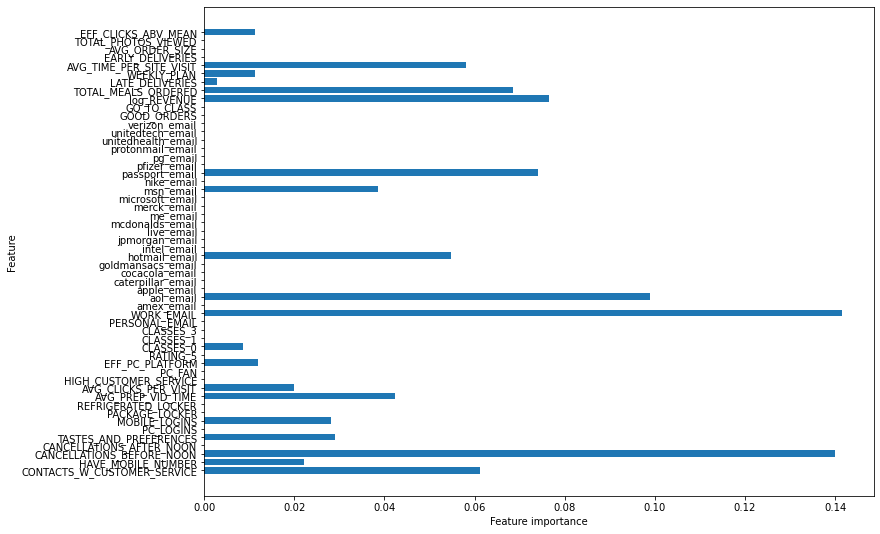

In [8]:
# INSTANTIATING a classification tree object
pruned_tree = DecisionTreeClassifier(max_depth = 8,
                                     min_samples_leaf = 25,
                                     random_state = 219)


# FITTING the training data
pruned_tree_fit  = pruned_tree.fit(x_train, y_train)


# PREDICTING on new data
pruned_tree_pred = pruned_tree_fit.predict(x_test)


# SCORING the model
print('Training ACCURACY:', pruned_tree_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', pruned_tree_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = pruned_tree_pred).round(4))


# saving scoring data for future use
pruned_tree_train_score = pruned_tree_fit.score(x_train, y_train).round(4) # accuracy
pruned_tree_test_score  = pruned_tree_fit.score(x_test, y_test).round(4)   # accuracy


# saving auc score
pruned_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                        y_score = pruned_tree_pred).round(4) # auc

# unpacking the confusion matrix
pruned_tree_tn, \
pruned_tree_fp, \
pruned_tree_fn, \
pruned_tree_tp = confusion_matrix(y_true = y_test, y_pred = pruned_tree_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {pruned_tree_tn}
False Positives: {pruned_tree_fp}
False Negatives: {pruned_tree_fn}
True Positives : {pruned_tree_tp}
""")

# calling display_tree
print(display_tree(tree       = pruned_tree_fit,
             feature_df = x_train))

# plotting feature importance
plot_feature_importances(pruned_tree_fit,
                         train = x_train,
                         export = False)

### Tuned LR

In [9]:
# Tuned LR
'''########################################
# RandomizedSearchCV
########################################

# declaring a hyperparameter space
C_space          = np.arange(0.1, 5.0, 0.1)
warm_start_space = [True, False]
solver_space     = ['newton-cg', 'sag','lbfgs']
multi_class_space= ['auto', 'ovr', 'multinomial']

# creating a hyperparameter grid
param_grid = {'C'          : C_space,
              'warm_start' : warm_start_space,
              'solver'     : solver_space,
              'multi_class': multi_class_space}


# INSTANTIATING the model object without hyperparameters
lr_tuned = LogisticRegression(random_state = 219,
                              max_iter     = 1000)


# GridSearchCV object
lr_tuned_cv = RandomizedSearchCV(estimator           = lr_tuned,   # the model object
                                 param_distributions = param_grid, # parameters to tune
                                 cv                  = 3,          # how many folds in cross-validation
                                 n_iter              = 1000,       # number of combinations of hyperparameters to try
                                 random_state        = 219,        # starting point for random sequence
                                 scoring = make_scorer(
                                           roc_auc_score,
                                           needs_threshold = False)) # scoring criteria (AUC)

# FITTING to the FULL DATASET (due to cross-validation)
lr_tuned_cv.fit(chef_data, chef_target)

# checking the best estimator for the model
# best params : {'warm_start': True, 'solver': 'lbfgs', 'multi_class': 'multinomial', 'C': 4.6}
# best estimator: LogisticRegression(C=4.6, max_iter=1000, multi_class='multinomial',
#                   random_state=219, warm_start=True)
# Tuned CV AUC      : 0.6233
'''

# INSTANTIATING a logistic regression model with tuned values
lr_tuned = LogisticRegression(C=4.6, max_iter=1000, multi_class='multinomial',
                   random_state=219, warm_start=True)

lr_tuned = lr_tuned.fit(chef_data, chef_target)

# PREDICTING based on the testing set
lr_tuned_pred = lr_tuned.predict(x_test)


# SCORING the results
print('Training ACCURACY:', lr_tuned.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', lr_tuned.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                  y_score = lr_tuned_pred).round(4))


# saving scoring data for future use
lr_tuned_train_score = lr_tuned.score(x_train, y_train).round(4) # accuracy
lr_tuned_test_score  = lr_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
lr_tuned_auc         = roc_auc_score(y_true  = y_test,
                                     y_score = lr_tuned_pred).round(4) # auc

# unpacking the confusion matrix
lr_tuned_tn, \
lr_tuned_fp, \
lr_tuned_fn, \
lr_tuned_tp = confusion_matrix(y_true = y_test, y_pred = lr_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {lr_tuned_tn}
False Positives: {lr_tuned_fp}
False Negatives: {lr_tuned_fn}
True Positives : {lr_tuned_tp}
""")

# declaring model performance objects
lr_tuned_train_acc = lr_tuned.score(x_train, y_train).round(4)
lr_tuned_test_acc  = lr_tuned.score(x_test, y_test).round(4)
lr_tuned_auc       = roc_auc_score(y_true  = y_test,
                              y_score = lr_tuned_pred).round(4)

Training ACCURACY: 0.7361
Testing  ACCURACY: 0.731
AUC Score        : 0.631

True Negatives : 55
False Positives: 101
False Negatives: 30
True Positives : 301



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Tuned Tree

Training ACCURACY: 0.7162
Testing  ACCURACY: 0.7125
AUC Score        : 0.5852

True Negatives : 36
False Positives: 120
False Negatives: 20
True Positives : 311



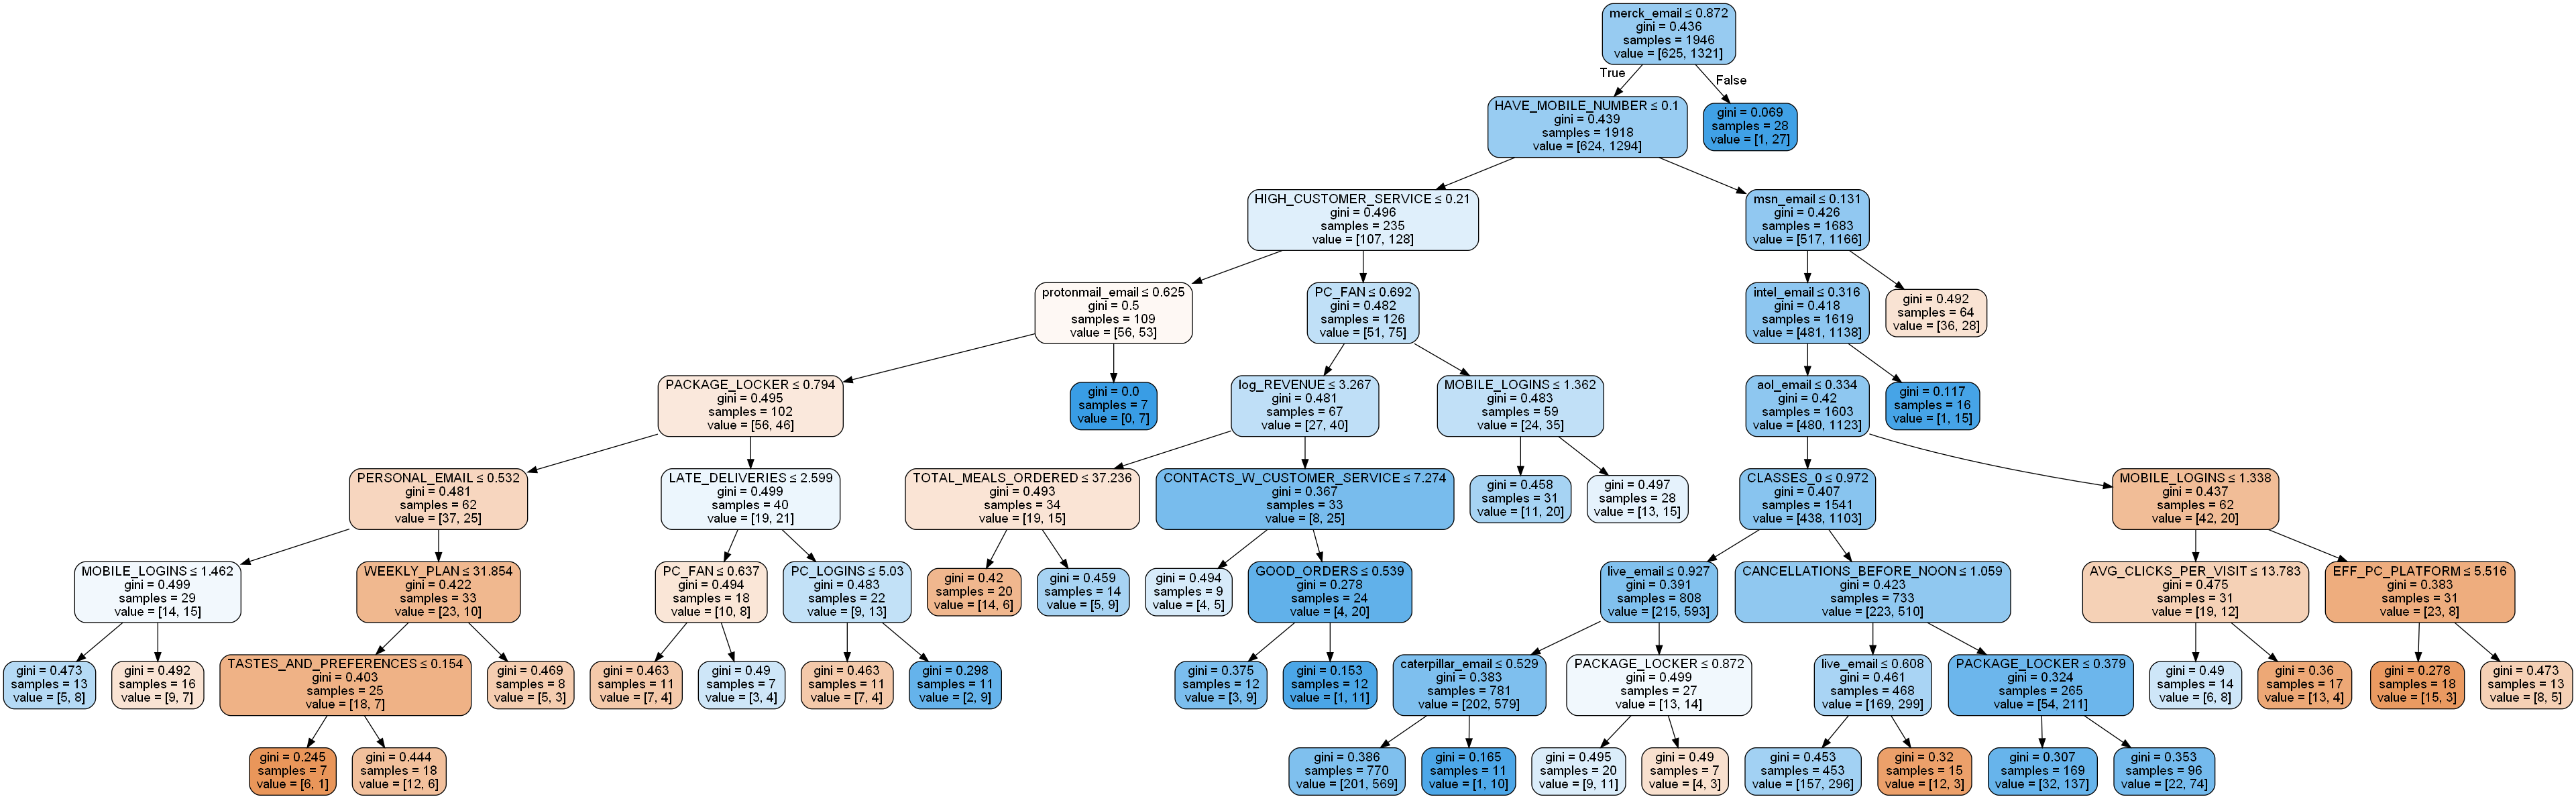

In [10]:
# Tuned Tree
'''
# declaring a hyperparameter space
criterion_space           = ['gini','entropy']
max_depth_space           = np.arange(1,8,1)
max_features_space        = ['auto','sqrt','log2']
min_samples_leaf_space    = np.arange(1,50,1)
splitter_space            = ['best','random']
depth_space               = [4,8]


# creating a hyperparameter grid
param_grid = {'criterion'           : criterion_space,
              'max_depth'           : max_depth_space,
              'max_features'        : max_features_space,
              'min_samples_leaf'    : min_samples_leaf_space,
              'splitter'            : splitter_space,
              'max_depth'           : depth_space}


# INSTANTIATING the model object without hyperparameters
tree_tuned = DecisionTreeClassifier(random_state =219)


# GridSearchCV object
tree_tuned_cv = RandomizedSearchCV(estimator         = tree_tuned,   # the model object
                                 param_distributions = param_grid, # parameters to tune
                                 cv                  = 3,          # how many folds in cross-validation
                                 n_iter              = 1000,        # number of combinations of hyperparameters to try
                                 random_state        = 219,        # starting point for random sequence
                                 scoring = make_scorer(
                                           roc_auc_score,
                                           needs_threshold = False)) # scoring criteria (AUC)


# FITTING to the FULL DATASET (due to cross-validation)
tree_tuned_cv.fit(chef_data, chef_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
print("Tuned Parameters  :", tree_tuned_cv.best_params_)
print("Tuned CV AUC      :", tree_tuned_cv.best_score_.round(4))

Tuned Parameters  : {'splitter': 'random', 'min_samples_leaf': 7, 'max_features': 'log2', 'max_depth': 8, 'criterion': 'gini'}
Tuned CV AUC      : 0.5982
Best Estimator    : DecisionTreeClassifier(max_depth=8, max_features='log2', min_samples_leaf=7,
                       random_state=219, splitter='random')
'''

# INSTANTIATING a logistic regression model with tuned values
tree_tuned = DecisionTreeClassifier(max_depth=8, max_features='log2', min_samples_leaf=7,
                       random_state=219, splitter='random')

# fitting
tree_tuned = tree_tuned.fit(chef_data, chef_target)

# PREDICTING based on the testing set
tree_tuned_pred = tree_tuned.predict(x_test)


# SCORING the results
print('Training ACCURACY:', tree_tuned.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', tree_tuned.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                  y_score = tree_tuned_pred).round(4))


# saving scoring data for future use
tree_tuned_train_score = tree_tuned.score(x_train, y_train).round(4) # accuracy
tree_tuned_test_score  = tree_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
tree_tuned_auc         = roc_auc_score(y_true  = y_test,
                                     y_score = tree_tuned_pred).round(4) # auc

# unpacking the confusion matrix
tuned_tree_tn, \
tuned_tree_fp, \
tuned_tree_fn, \
tuned_tree_tp = confusion_matrix(y_true = y_test, y_pred = tree_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_tree_tn}
False Positives: {tuned_tree_fp}
False Negatives: {tuned_tree_fn}
True Positives : {tuned_tree_tp}
""")

# declaring model performance objects
tree_train_acc = tree_tuned.score(x_train, y_train).round(4)
tree_test_acc  = tree_tuned.score(x_test, y_test).round(4)
tree_auc       = roc_auc_score(y_true  = y_test,
                              y_score = tree_tuned_pred).round(4)

# displaying the tree
# calling display_tree
display_tree(tree       = tree_tuned,
             feature_df = x_train)

### Random Forest

Training ACCURACY: 1.0
Testing  ACCURACY: 0.7064
AUC Score        : 0.5857

True Negatives : 39
False Positives: 117
False Negatives: 26
True Positives : 305



<ipython-input-3-b0e77273b66b>:195: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  plt.yticks(pd.np.arange(n_features), train.columns)


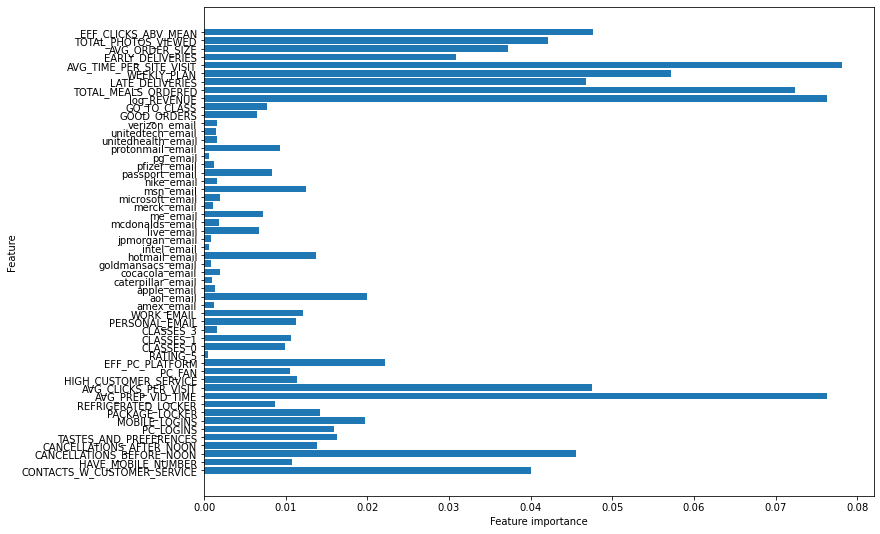

In [11]:
# Random Forest
# INSTANTIATING a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 100,
                                    criterion        = 'gini',
                                    max_depth        = None,
                                    min_samples_leaf = 1, 
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 219)
# FITTING the training data
rf_default_fit = rf_default.fit(x_train, y_train)


# PREDICTING based on the testing set
rf_default_fit_pred = rf_default_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', rf_default_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', rf_default_fit.score(x_test, y_test).round(4))


# saving AUC score
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = rf_default_fit_pred).round(4))

# plotting feature importances
plot_feature_importances(rf_default_fit,x_train)

# unpacking the confusion matrix
rf_tn, \
rf_fp, \
rf_fn, \
rf_tp = confusion_matrix(y_true = y_test, y_pred = rf_default_fit_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {rf_tn}
False Positives: {rf_fp}
False Negatives: {rf_fn}
True Positives : {rf_tp}
""")

# declaring model performance objects
rf_train_acc = rf_default_fit.score(x_train, y_train).round(4)
rf_test_acc  = rf_default_fit.score(x_test, y_test).round(4)
rf_auc       = roc_auc_score(y_true  = y_test,
                             y_score = rf_default_fit_pred).round(4)


### Tuned Random Forest

Forest Tuned Training ACCURACY: 0.8047
Forest Tuned Testing  ACCURACY: 0.8214
Forest Tuned AUC Score        : 0.7212


<ipython-input-3-b0e77273b66b>:195: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  plt.yticks(pd.np.arange(n_features), train.columns)



True Negatives : 69
False Positives: 87
False Negatives: 0
True Positives : 331



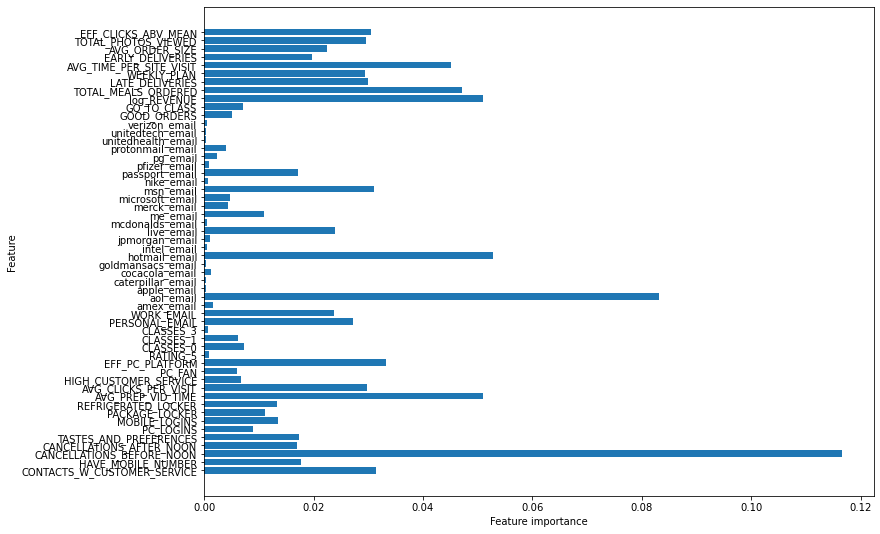

In [12]:
# Tuned Random Forest
'''
# declaring a hyperparameter space
estimator_space  = np.arange(100, 1100, 250)
leaf_space       = np.arange(1, 31, 5)
criterion_space  = ['gini', 'entropy']
bootstrap_space  = [True, False]
warm_start_space = [True, False]
max_depth_space  = [4,8]

# creating a hyperparameter grid
param_grid = {'n_estimators'     : estimator_space,
              'min_samples_leaf' : leaf_space,
              'criterion'        : criterion_space,
              'bootstrap'        : bootstrap_space,
              'warm_start'       : warm_start_space,
              'max_depth'        : max_depth_space}


# INSTANTIATING the model object without hyperparameters
forest_grid = RandomForestClassifier(random_state = 219)


# GridSearchCV object
forest_cv = RandomizedSearchCV(estimator           = forest_grid,
                               param_distributions = param_grid,
                               cv         = 3,
                               n_iter     = 1000,
                               scoring    = make_scorer(roc_auc_score,
                                            needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
forest_cv.fit(chef_data, chef_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
print("Tuned Parameters  :", forest_cv.best_params_)
print("Tuned Training AUC:", forest_cv.best_score_.round(4))

# best estimators based on RandomizedSearchCV
print(forest_cv.best_estimator_)

Tuned Parameters  : {'warm_start': True, 'n_estimators': 350, 'min_samples_leaf': 1, 'max_depth': 8, 'criterion': 'gini', 'bootstrap': False}
Tuned Training AUC: 0.5623
Best Estimator    : RandomForestClassifier(bootstrap=False, max_depth=8, n_estimators=350,
                       random_state=219, warm_start=True)
'''
# building a model based on hyperparameter tuning results

# to avoid running another RandomizedSearch
forest_tuned = RandomForestClassifier(bootstrap=False, max_depth=8, n_estimators=350,
                       random_state=219, warm_start=True)

# FITTING the model object
forest_tuned_fit = forest_tuned.fit(chef_data, chef_target)


# PREDICTING based on the testing set
forest_tuned_pred = forest_tuned_fit.predict(x_test)


# SCORING the results
print('Forest Tuned Training ACCURACY:', forest_tuned.score(x_train, y_train).round(4))
print('Forest Tuned Testing  ACCURACY:', forest_tuned.score(x_test, y_test).round(4))
print('Forest Tuned AUC Score        :', roc_auc_score(y_true  = y_test,
                                                       y_score = forest_tuned_pred).round(4))


# saving scoring data for future use
forest_tuned_train_score = forest_tuned.score(x_train, y_train).round(4) # accuracy
forest_tuned_test_score  = forest_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
forest_tuned_auc = roc_auc_score(y_true  = y_test,
                                 y_score = forest_tuned_pred).round(4) # auc

# plotting feature importances
plot_feature_importances(forest_tuned_fit,
                         train = x_train,
                         export = False)

# unpacking the confusion matrix
tuned_rf_tn, \
tuned_rf_fp, \
tuned_rf_fn, \
tuned_rf_tp = confusion_matrix(y_true = y_test, y_pred = forest_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {tuned_rf_tn}
False Positives: {tuned_rf_fp}
False Negatives: {tuned_rf_fn}
True Positives : {tuned_rf_tp}
""")

# declaring model performance objects
tuned_rf_train_acc = forest_tuned_fit.score(x_train, y_train).round(4)
tuned_rf_test_acc  = forest_tuned_fit.score(x_test, y_test).round(4)
tuned_rf_auc       = roc_auc_score(y_true  = y_test,
                                   y_score = forest_tuned_pred).round(4)

### Gradient Boosted Models (GBM)

In [13]:
# GBM
# INSTANTIATING the model object without hyperparameters
full_gbm_default = GradientBoostingClassifier(loss          = 'deviance',
                                              learning_rate = 0.1, 
                                              n_estimators  = 100, 
                                              criterion     = 'friedman_mse',
                                              max_depth     = 8,
                                              warm_start    = False,
                                              random_state  = 219)


# FIT step is needed as we are not using .best_estimator
full_gbm_default_fit = full_gbm_default.fit(x_train, y_train)


# PREDICTING based on the testing set
full_gbm_default_pred = full_gbm_default_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', full_gbm_default_fit.score(x_train, y_train).round(4))
print('Testing ACCURACY :', full_gbm_default_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = full_gbm_default_pred).round(4))

# unpacking the confusion matrix
gbm_default_tn, \
gbm_default_fp, \
gbm_default_fn, \
gbm_default_tp = confusion_matrix(y_true = y_test, y_pred = full_gbm_default_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {gbm_default_tn}
False Positives: {gbm_default_fp}
False Negatives: {gbm_default_fn}
True Positives : {gbm_default_tp}
""")

# SCORING the model
gbm_train_acc = full_gbm_default_fit.score(x_train, y_train).round(4)
gbm_test_acc  = full_gbm_default_fit.score(x_test, y_test).round(4)
gbm_auc       = roc_auc_score(y_true  = y_test,
                              y_score = full_gbm_default_pred).round(4)


Training ACCURACY: 0.9966
Testing ACCURACY : 0.6899
AUC Score        : 0.5889

True Negatives : 48
False Positives: 108
False Negatives: 43
True Positives : 288



### Tuned Gradient Boosted Models (GBM)

In [14]:
# Tuned GBM
'''
# declaring a hyperparameter space
learn_space        = np.arange(0.1,5,0.1)
estimator_space    = np.arange(100,1100,250)
depth_space        = [4,8]
warm_start_space   = [True, False]
max_features_space = ['auto','sqrt','log2',None]


# creating a hyperparameter grid
param_grid = {'learning_rate'   : learn_space,
              'max_depth'       : depth_space,
              'n_estimators'    : estimator_space,
              'max_features'    : max_features_space,
              'warm_start'      : warm_start_space}


# INSTANTIATING the model object without hyperparameters
full_gbm_grid = GradientBoostingClassifier(random_state = 219)


# GridSearchCV object
full_gbm_cv = RandomizedSearchCV(estimator           = full_gbm_grid,
                               param_distributions   = param_grid,
                                 cv                  = 3,
                                 n_iter              = 1000,
                                 random_state        = 219,
                                 scoring             = make_scorer(roc_auc_score,
                                                       needs_threshold = False))

# FITTING to the FULL DATASET (due to cross-validation)
full_gbm_cv.fit(chef_data, chef_target)

# printing the optimal parameters and best score
print("Tuned Parameters  :", full_gbm_cv.best_params_)
print("Tuned Training AUC:", full_gbm_cv.best_score_.round(4))

Tuned Parameters  : {'warm_start': False, 'n_estimators': 850, 'max_features': 'log2', 'max_depth': 8, 'learning_rate': 0.9}
Tuned Training AUC: 0.6326
Best Estimator    : GradientBoostingClassifier(learning_rate=0.9, max_depth=8, max_features='log2',
                           n_estimators=850, random_state=219)

'''
# INSTANTIATING the model object without hyperparameters

gbm_tuned = GradientBoostingClassifier(learning_rate=0.9, max_depth=8, max_features='log2',
                           n_estimators=850, random_state=219)

# FIT step is needed as we are not using .best_estimator
gbm_tuned_fit = gbm_tuned.fit(chef_data, chef_target)


# PREDICTING based on the testing set
gbm_tuned_pred = gbm_tuned_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', gbm_tuned_fit.score(x_train, y_train).round(4))
print('Testing  ACCURACY:', gbm_tuned_fit.score(x_test, y_test).round(4))
print('AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = gbm_tuned_pred).round(4))



# unpacking the confusion matrix
gbm_tuned_tn, \
gbm_tuned_fp, \
gbm_tuned_fn, \
gbm_tuned_tp = confusion_matrix(y_true = y_test, y_pred = gbm_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {gbm_tuned_tn}
False Positives: {gbm_tuned_fp}
False Negatives: {gbm_tuned_fn}
True Positives : {gbm_tuned_tp}
""")

# declaring model performance objects
gbm_tuned_train_acc = gbm_tuned_fit.score(x_train, y_train).round(4)
gbm_tuned_test_acc  = gbm_tuned_fit.score(x_test, y_test).round(4)
gbm_tuned_auc = roc_auc_score(y_true  = y_test,
                              y_score = gbm_tuned_pred).round(4)

Training ACCURACY: 1.0
Testing  ACCURACY: 1.0
AUC Score        : 1.0

True Negatives : 156
False Positives: 0
False Negatives: 0
True Positives : 331



## Summary of the models and choosing the optimal

In [15]:
# comparing results
print(f"""
Model                           AUC Score      TN, FP, FN, TP
-----                           ---------      --------------
Logistic                        {logreg_auc_score}         {logreg_tn, logreg_fp, logreg_fn, logreg_tp}
Full Tree                       {full_tree_auc_score}         {full_tree_tn, full_tree_fp, full_tree_fn, full_tree_tp}
Pruned Tree                     {pruned_tree_auc_score}         {pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp}
LR Tuned                        {lr_tuned_auc}          {lr_tuned_tn, lr_tuned_fp, lr_tuned_fn, lr_tuned_tp}
Tuned Tree                      {tree_auc}         {tuned_tree_tn,tuned_tree_fp,tuned_tree_fn,tuned_tree_tp}
Random Forest (Full)            {rf_auc}         {rf_tn,rf_fp,rf_fn,rf_tp}
Tuned Random Forest (Full)      {tuned_rf_auc}         {tuned_rf_tn,tuned_rf_fp,tuned_rf_fn,tuned_rf_tp}
GBM (Full)                      {gbm_auc}         {gbm_default_tn, gbm_default_tp, gbm_default_fn, gbm_default_tp}
Tuned GBM                       {gbm_tuned_auc}            {gbm_tuned_tn, gbm_tuned_fp, gbm_tuned_fn, gbm_tuned_tp}
""")


# creating a dictionary for model results
model_performance = {
    
    'Model Name'    : ['Logistic', 'Full Tree', 'Pruned Tree','LR Tuned'],
           
    'AUC Score' : [logreg_auc_score, full_tree_auc_score, pruned_tree_auc_score,lr_tuned_auc],
    
    'Training Accuracy' : [logreg_train_score, full_tree_train_score,
                           pruned_tree_train_score, lr_tuned_train_score],
           
    'Testing Accuracy'  : [logreg_test_score, full_tree_test_score,
                           pruned_tree_test_score, lr_tuned_test_score],

    'Confusion Matrix'  : [(logreg_tn, logreg_fp, logreg_fn, logreg_tp),
                           (full_tree_tn, full_tree_fp, full_tree_fn, full_tree_tp),
                           (pruned_tree_tn, pruned_tree_fp, pruned_tree_fn, pruned_tree_tp),
                           (lr_tuned_tn, lr_tuned_fp, lr_tuned_fn, lr_tuned_tp)]}


# converting model_performance into a DataFrame
model_performance = pd.DataFrame(model_performance)


# appending to model_performance Tuned Tree
model_performance = model_performance.append(
                          {'Model Name'        : 'Tuned Tree',
                           'Training Accuracy' : tree_train_acc,
                           'Testing Accuracy'  : tree_test_acc,
                           'AUC Score'         : tree_auc,
                           'Confusion Matrix'  : (tuned_tree_tn,
                                                  tuned_tree_fp,
                                                  tuned_tree_fn,
                                                  tuned_tree_tp)},
                           ignore_index = True)

# appending to model_performance Random Forest
model_performance = model_performance.append(
                          {'Model Name'         : 'Random Forest (Full)',
                           'Training Accuracy'  : rf_train_acc,
                           'Testing Accuracy'   : rf_test_acc,
                           'AUC Score'          : rf_auc,
                           'Confusion Matrix'   : (rf_tn,
                                                   rf_fp,
                                                   rf_fn,
                                                   rf_tp)},
                          ignore_index = True)

# appending to model_performance Tuned Random Forest
model_performance = model_performance.append(
                          {'Model Name'         : 'Tuned Random Forest (Full)',
                           'Training Accuracy'  : tuned_rf_train_acc,
                           'Testing Accuracy'   : tuned_rf_test_acc,
                           'AUC Score'          : tuned_rf_auc,
                           'Confusion Matrix'   : (tuned_rf_tn,
                                                   tuned_rf_fp,
                                                   tuned_rf_fn,
                                                   tuned_rf_tp)},
                          ignore_index = True)


# appending to model_performance GBM
model_performance = model_performance.append(
                          {'Model Name'       : 'GBM (Full)',
                          'Training Accuracy' : gbm_train_acc,
                          'Testing Accuracy'  : gbm_test_acc,
                          'AUC Score'         : gbm_auc,
                          'Confusion Matrix'  : (  gbm_default_tn,
                                                   gbm_default_tp,
                                                   gbm_default_fn,
                                                   gbm_default_tp)},
                          ignore_index = True)

# appending to model_performance Tuned GBM
model_performance = model_performance.append(
                          {'Model Name'        : 'Tuned GBM',
                          'Training Accuracy'  : gbm_tuned_train_acc,
                          'Testing Accuracy'   : gbm_tuned_test_acc,
                          'AUC Score'          : gbm_tuned_auc,
                          'Confusion Matrix'   : (gbm_tuned_tn,
                                                  gbm_tuned_fp,
                                                  gbm_tuned_fn,
                                                  gbm_tuned_tp)},
                          ignore_index = True)

# checking the results
print(model_performance)


# sending model results to Excel
model_performance.to_excel('./classification_model_performance.xlsx',
                           index = False)


Model                           AUC Score      TN, FP, FN, TP
-----                           ---------      --------------
Logistic                        0.5332         (16, 140, 12, 319)
Full Tree                       0.5377         (57, 99, 96, 235)
Pruned Tree                     0.5872         (47, 109, 42, 289)
LR Tuned                        0.631          (55, 101, 30, 301)
Tuned Tree                      0.5852         (36, 120, 20, 311)
Random Forest (Full)            0.5857         (39, 117, 26, 305)
Tuned Random Forest (Full)      0.7212         (69, 87, 0, 331)
GBM (Full)                      0.5889         (48, 288, 43, 288)
Tuned GBM                       1.0            (156, 0, 0, 331)

                   Model Name  AUC Score  Training Accuracy  Testing Accuracy    Confusion Matrix
0                    Logistic     0.5332             0.7046            0.6879  (16, 140, 12, 319)
1                   Full Tree     0.5377             1.0000            0.5996   (57, 99, 

### Winning model and values

Our top models considering our parameters of <0.05 gap and higher AUC are as follows where I have decided to choose **Tuned Random Forest (Full)** as our winner model since the Tuned GBM seems overfitted. 

In [16]:
# Printing top 2
print(f"""
Model                                   AUC Score      TN, FP, FN, TP
-----                                   ---------      --------------
Tuned GBM - SEEMS OVERFITTED            {gbm_tuned_auc}            {gbm_tuned_tn, gbm_tuned_fp, gbm_tuned_fn, gbm_tuned_tp}
Tuned Random Forest (Full)  - WINNER    {tuned_rf_auc}         {tuned_rf_tn,tuned_rf_fp,tuned_rf_fn,tuned_rf_tp}
""")


Model                                   AUC Score      TN, FP, FN, TP
-----                                   ---------      --------------
Tuned GBM - SEEMS OVERFITTED            1.0            (156, 0, 0, 331)
Tuned Random Forest (Full)  - WINNER    0.7212         (69, 87, 0, 331)

